# QUBO for Photomosaic Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/phosaiq/phosaiq-scratch/blob/main/notebooks/example_qubo.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/phosaiq/phosaiq-scratch/main?labpath=notebooks%2Fexample_qubo.ipynb)

1. Load images
2. Preprocess images
3. Prepare for input data
4. Create QUBO model
5. Solve problem
6. Visualize objective values
7. Postprocess results

In [ ]:
# !pip install numpy
# !pip install matplotlib
# !pip install opencv-python
# !pip install scikit-image
# !pip install dwave-ocean-sdk
# !pip install tqdm

In [1]:
import collections
import glob
import os

import cv2
import dimod
import matplotlib.pyplot as plt
import numpy as np
import skimage.color
from tqdm import tqdm

## Load images

- material images
- target image

In this notebook, we use images posted by [@hanae0626](https://twitter.com/hanae0626) in X (Twitter).

In [2]:
def load_images(image_paths: list[str], **options) -> dict[str, np.ndarray]:
    images = {}
    for path in tqdm(image_paths):
        try:
            image = cv2.imread(path, **options)
        except Exception as e:
            print(f"Failed to load file: {path}")
            continue

        if image is not None:
            images[path] = image
    return images

def plot_image(image: np.ndarray):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [3]:
path_material_image_dir = "../data/hanae0626/images"

paths_material_image = glob.glob(path_material_image_dir + '/*')
material_images = load_images(paths_material_image)
print(f"# of material images: {len(material_images)}")

  0%|          | 0/1516 [00:00<?, ?it/s]

100%|██████████| 1516/1516 [00:13<00:00, 116.15it/s]

# of material images: 1516


../data/hanae0626/images/hanae0626-191118061830000000.jpg


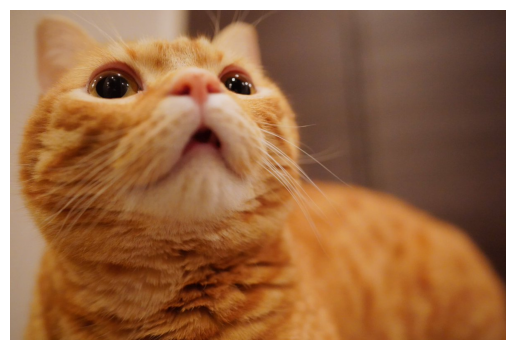

In [4]:
for file_name, image in material_images.items():
    print(file_name)
    plot_image(image)
    break

In [6]:
path_target_image = "../data/hanae0626/target_image.jpg"

target_image = load_images([path_target_image])[path_target_image]
print(f"target_image.shape: {target_image.shape}")

100%|██████████| 1/1 [00:00<00:00, 105.08it/s]

target_image.shape: (800, 1200, 3)


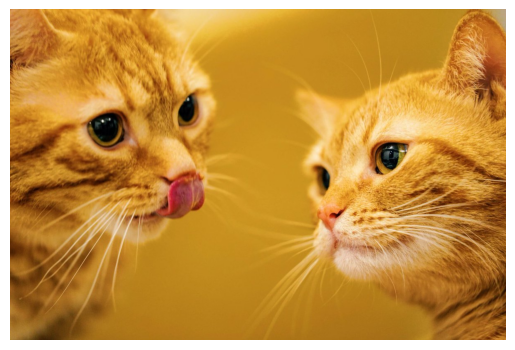

In [7]:
plot_image(target_image)

## Preprocess images

### Target image

1. calculate the number of tiles
2. split target image to tiles

In [8]:
def calculate_num_tiles(image: np.ndarray, row: int) -> tuple[int, int, int]:
    height, width, _ = image.shape
    tile_size = int(np.ceil(height / row))
    column = int(np.ceil(width / tile_size))
    return row, column, tile_size

In [9]:
row = 40

row, column, tile_size = calculate_num_tiles(target_image, row=row)
print(f"tile_size: {tile_size}")
print(f"row: {row}, column: {column}")

tile_size: 20
row: 40, column: 60


In [10]:
def split_image(image: np.ndarray, row: int, column: int, tile_size: int) -> dict[tuple[int, int], np.ndarray]:
    position_tile_images = {}
    for i in range(row - 1):
        for j in range(column - 1):
            position = (i, j)
            position_tile_images[position] = image[
                i * tile_size : (i + 1) * tile_size, j * tile_size : (j + 1) * tile_size, :
            ]

    # Last row
    for j in range(column - 1):
        position = (row - 1, j)
        position_tile_images[position] = image[
            (row - 1) * tile_size :, j * tile_size : (j + 1) * tile_size, :
        ]

    # Last column
    for i in range(row - 1):
        position = (i, column - 1)
        position_tile_images[position] = image[
            i * tile_size : (i + 1) * tile_size, (column - 1) * tile_size :, :
        ]

    # Last tile
    position = (row - 1, column - 1)
    position_tile_images[position] = image[(row - 1) * tile_size :, (column - 1) * tile_size :, :]

    return position_tile_images

In [11]:
position_tile_images = split_image(target_image, row, column, tile_size)

### Material images

1. crop images to square
2. resize images to tile size
3. augment images by horizontal flipping

In [12]:
def crop_image_center(image: np.ndarray) -> np.ndarray:
    h, w = image.shape[:2]
    size = min(h, w)

    if h > w:
        x, y = (0, (h - size) // 2)
    else:
        x, y = ((w - size) // 2, 0)

    return image[y : y + size, x : x + size]

In [13]:
material_images_cropped = {}
for path, image in material_images.items():
    material_images_cropped[path] = crop_image_center(image)

In [14]:
material_images_resized = {}
for path, image in material_images_cropped.items():
    material_images_resized[path] = cv2.resize(image, (tile_size, tile_size))

In [15]:
def flip_image(image: np.ndarray) -> np.ndarray:
    return cv2.flip(image, 1)

In [19]:
material_images_augmented = {}
for path, image in material_images_resized.items():
    material_images_augmented[path] = image
    material_images_augmented[path + " flip"] = flip_image(image)

## Prepare for input data

- color differences between tiles and material images
- reduce variables (arrangement candidates) by color differences

In [21]:
def calculate_color_diffs(
    tile_images: dict[tuple[int, int], np.ndarray], material_images: dict[str, np.ndarray], pixel_size: int = 8
) -> dict[tuple[tuple[int, int], str], float]:
    def resize_and_convert_to_lab(image: np.ndarray) -> np.ndarray:
        return cv2.cvtColor(cv2.resize(image, (pixel_size, pixel_size)), cv2.COLOR_BGR2LAB)

    tile_images_lab = np.array(list(map(resize_and_convert_to_lab, tile_images.values())))
    material_images_lab = np.array(list(map(resize_and_convert_to_lab, material_images.values())))

    deltaE_cie76 = np.mean(
        skimage.color.deltaE_cie76(
            tile_images_lab[:, np.newaxis, ...],
            material_images_lab[np.newaxis, :, ...]
        ),
        axis=(2, 3)
    )
    deltaE_cie76 /= np.max(deltaE_cie76)

    color_diffs = {}
    for i, target_key in enumerate(tile_images.keys()):
        for j, material_key in enumerate(material_images.keys()):
            color_diffs[(target_key, material_key)] = deltaE_cie76[i, j]

    return color_diffs

In [22]:
resize_pixel = 8
color_diffs = calculate_color_diffs(position_tile_images, material_images_resized, pixel_size=resize_pixel)

In [23]:
def add_noise_to_color_diffs(
    color_diffs: dict[tuple[tuple[int, int], str], float], std_noise: float = 0.02
) -> dict[tuple[tuple[int, int], str], float]:
    color_diffs_noised = {}
    for key, value in color_diffs.items():
        color_diffs_noised[key] = min(1.0, max(0.0, value + np.random.normal(0, std_noise)))
    return color_diffs_noised

In [24]:
std_noise = 0.02
color_diffs_noise = add_noise_to_color_diffs(color_diffs, std_noise=std_noise)

In [25]:
def reduce_arrangement_candidates(
    color_diffs: dict[tuple[tuple[int, int], str], float], max_candidates: int = 10
) -> dict[tuple[int, int], list[str]]:
    target_material_color_diffs = collections.defaultdict(list)
    for (target_key, material_key), color_diff in color_diffs.items():
        target_material_color_diffs[target_key].append((material_key, color_diff))

    arrangement_candidates = {}
    for target_key, candidates in target_material_color_diffs.items():
        arrangement_candidates[target_key] = [
            material_key
            for material_key, _ in sorted(candidates, key=lambda x: x[1])[:max_candidates]
        ]

    return arrangement_candidates

In [26]:
max_candidates = 10
tile_materials = reduce_arrangement_candidates(color_diffs_noise, max_candidates=max_candidates)
print(f"# of candidates: {sum(map(len, tile_materials.values()))}")

# of candidates: 24000


In [27]:
material_tiles = collections.defaultdict(list)
for tile_key, material_keys in tile_materials.items():
    for material_key in material_keys:
        material_tiles[material_key].append(tile_key)
material_tiles = dict(material_tiles)

## Create QUBO model

### Variables

- $x_{\mu i} \in \{0,1\}$: 1 if material image $\mu$ is assigned to tile $i$, 0 otherwise

In [28]:
variables = collections.defaultdict(lambda: 0)
for tile_key, material_keys in tile_materials.items():
    for material_key in material_keys:
        variables[(tile_key, material_key)] = dimod.Binary((tile_key, material_key))

### Objectives

- Similarity: to minimize the sum of color differences $D_{\mu i}$ added noise $\epsilon_{\mu i}$

$$
H_{\text{similarity}} = \sum_{\mu \in M} \sum_{i \in I} \left(D_{\mu i} + \epsilon_{\mu i} \right) x_{\mu i}
$$

In [29]:
similarity_objective = 0.0
for (tile_key, material_key), color_diff in color_diffs_noise.items():
    similarity_objective += color_diff * variables[(tile_key, material_key)]

- Duplication: to minimize the number of each material image is assigned

$$
H_{\text{duplication}} = \sum_{\mu \in M} \left( \sum_{i \in I_{\mu}} x_{\mu i} \right)^2
$$

In [30]:
duplication_objective = 0.0
for material_key, tile_keys in material_tiles.items():
    duplication_objective += sum(variables[(tile_key, material_key)] for tile_key in tile_keys)**2

### Constraints

- Material onehot: to assign only one material image to each tile

$$
H_{\text{onehot}} = \sum_{i \in I} \left( \sum_{\mu \in M_i} x_{\mu i} - 1 \right)^2
$$

In [31]:
onehot_penalty = 0.0
for tile_key, material_keys in tile_materials.items():
    onehot_penalty += (sum(variables[(tile_key, material_key)] for material_key in material_keys) - 1)**2

### Cost function

$$
H = \lambda_{\text{similarity}} H_{\text{similarity}} + \lambda_{\text{duplication}} H_{\text{duplication}} + \lambda_{\text{onehot}} H_{\text{onehot}}
$$

In [32]:
weights = {
    "similarity": 1.0,
    "duplication": 1.0,
    "onehot": 100.0,
}

cost_function = (
    similarity_objective * weights["similarity"]
    + duplication_objective * weights["duplication"]
    + onehot_penalty * weights["onehot"]
)

## Solve problem

1. set solver
2. execute sampling
3. check feasibility of sample

In [33]:
# Use D-Wave Hybrid Solver
# from dwave.system import LeapHybridSampler
# token = "YOUR_API_TOKEN"
# sampler = LeapHybridSampler(token=token)
# sample_options = {}

# Use Simulated Annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()
sample_options = {"num_reads": 5, "num_sweeps": 1000}

In [34]:
sampleset = sampler.sample(cost_function, **sample_options)

In [35]:
def check_onehot_constraint(sample: dict):
    for tile_key in tile_materials.keys():
        material_keys = tile_materials[tile_key]
        if sum(sample[(tile_key, material_key)] for material_key in material_keys) != 1:
            return False
    return True

In [36]:
check_onehot_constraint(sampleset.first.sample)

True

In [37]:
def sample_to_arrangement(sample: dict) -> dict[str, list[tuple[int, int]]]:
    arrangement = collections.defaultdict(list)
    for (tile_key, material_key), value in sample.items():
        if value == 1:
            arrangement[material_key].append(tile_key)
    return dict(arrangement)

In [38]:
arrangement = sample_to_arrangement(sampleset.first.sample)

## Visualize objective values

In [39]:
def calculate_similarity(arrangement: dict[str, list[tuple[int, int]]]) -> float:
    similarity = 0.0
    for material_key, tile_keys in arrangement.items():
        for tile_key in tile_keys:
            similarity += color_diffs[(tile_key, material_key)]
    return similarity

In [40]:
similarity = calculate_similarity(arrangement)
print(f"Similarity: {similarity}")

Similarity: 375.3310447766533


In [41]:
def calculate_duplication(arrangement: dict[str, list[tuple[int, int]]]) -> dict[str, int]:
    duplications = collections.defaultdict(lambda: 0)
    for material_key, tile_keys in arrangement.items():
        duplications[material_key] += len(tile_keys)
    return dict(duplications)

def plot_duplication(duplications: dict[str, int]):
    plt.bar(range(len(duplications)), sorted(duplications.values(), reverse=True))
    plt.xlabel("Index of material image (sorted)")
    plt.ylabel("# of tiles")
    plt.show()

In [42]:
duplications = calculate_duplication(arrangement)
print(f"Duplication objective: {sum(map(lambda x: x**2, duplications.values()))}")
print(f"Max duplication: {max(duplications.values())}")

Duplication objective: 38650
Max duplication: 33


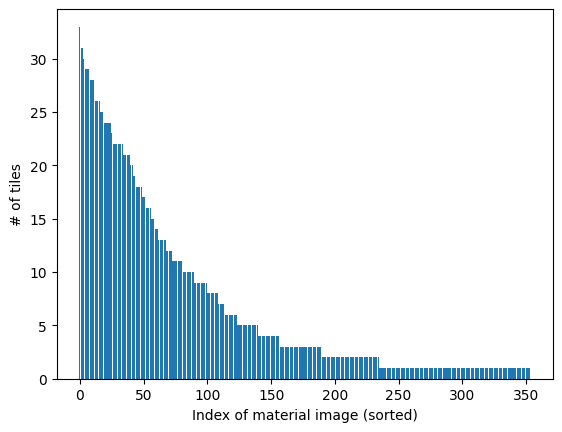

In [43]:
plot_duplication(duplications)

## Postprocess results

- construct mosaic image
- overlay target image to mosaic image

In [44]:
def construct_mosaic_image(
    arrangement: dict[str, list[tuple[int, int]]],
    row: int,
    column: int,
    tile_size: int,
    target_image: np.ndarray,
    material_images: dict[str, np.ndarray],
) -> np.ndarray:
    mosaic_image = np.zeros(shape=(row * tile_size, column * tile_size, 3), dtype=np.uint8)
    for material_key, tile_keys in arrangement.items():
        for (r, c) in tile_keys:
            material_image = material_images[material_key]
            mosaic_image[
                r * tile_size : (r + 1) * tile_size,
                c * tile_size : (c + 1) * tile_size,
            ] = material_image

    return mosaic_image[: target_image.shape[0], : target_image.shape[1]]

In [45]:
mosaic_image = construct_mosaic_image(arrangement, row, column, tile_size, target_image, material_images_resized)

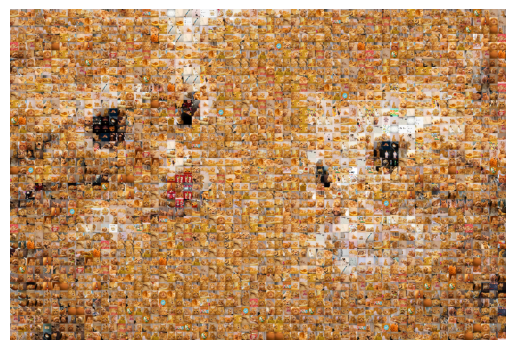

In [46]:
plot_image(mosaic_image)

In [47]:
def overlay_images(image1: np.ndarray, image2: np.ndarray, alpha: float = 0.3):
    if image1.shape[:2] != image2.shape[:2]:
        h, w = image1.shape[:2]
        image2 = cv2.resize(image2, (w, h))

    return cv2.addWeighted(image1, alpha, image2, 1 - alpha, 0)

In [48]:
alpha = 0.3
overlayed_image = overlay_images(target_image, mosaic_image, alpha=alpha)

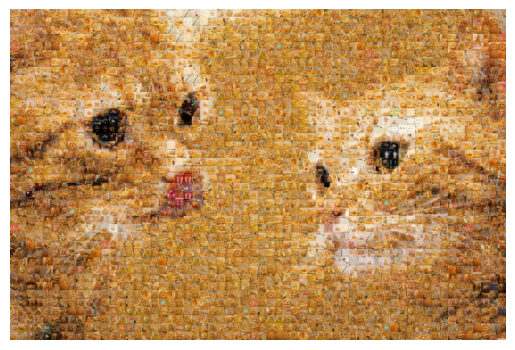

In [49]:
plot_image(overlayed_image)

In [50]:
path_output_dir = "../outputs/hanae0626"
os.makedirs(path_output_dir, exist_ok=True)

cv2.imwrite(os.path.join(path_output_dir, "mosaic_image.jpg"), mosaic_image)
cv2.imwrite(os.path.join(path_output_dir, f"mosaic_image_overlayed{int(alpha * 100)}.jpg"), overlayed_image)

True